# Data extraction and preprocessing

This notebook deals with the extraction and reformatting of the data. The data dataset considered in this notebook is the CMU movie summary corpus dataset. It was downloaded as a tar.gz file from https://www.cs.cmu.edu/~ark/personas/.

In this notebook the necessary data is loaded and the texts as well as the genres are preprocessed in order to be joined into one dataframe. Furthermore, some visualisations of the generated data are presented.

## Libraries

In [18]:
import pandas as pd
import requests
import tarfile
import json
import regex as re
import string
from wordcloud import WordCloud
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from collections import Counter

## Data extraction

### Loading the data

In [63]:
# Check if MovieSummaries.tar.gz exists, download and decompress
try:
    open('MovieSummaries.tar.gz')
except FileNotFoundError:
    print("Downloading MovieSummaries.tar.gz, decompressing, and saving to ./Data")
    url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    r = requests.get(url)
    with open('MovieSummaries.tar.gz', 'wb') as f:
        f.write(r.content)
    # Decompress downloaded data
    with tarfile.open('MovieSummaries.tar.gz') as f:
        f.extractall('./Data')

In [64]:
# Read data - files are eighter saved as .txt or as tsv-format (tab separated)
df_character_metadata = pd.read_csv('Data/MovieSummaries/character.metadata.tsv', delimiter='\t', header=None)
df_movie_metadata = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', delimiter='\t', header=None)
df_name_cluster = pd.read_csv('Data/MovieSummaries/name.clusters.txt', delimiter='\t', header=None)
df_plot_summary = pd.read_csv('Data/MovieSummaries/plot_summaries.txt', delimiter='\t', header=None)
df_tvtrope_cluster = pd.read_csv('Data/MovieSummaries/tvtropes.clusters.txt', delimiter='\t', header=None)

### Preliminary text preprocessing

In [65]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove extra spaces
    text = re.sub(r' +', ' ', text)
    #remove leading and trailing spaces
    text = text.strip()
    return text


In [66]:
# If plot_summaries.csv exists, read it, else create it
try:
    df_plot_summary = pd.read_csv('Data/MovieSummaries/plot_summaries.csv').iloc[: , 1:]
except FileNotFoundError:
    print('Creating plot_summaries.csv')
    # Preprocess the text
    df_plot_summary[1] = df_plot_summary[1].apply(preprocess_text)
    # Save the preprocessed data
    df_plot_summary.to_csv('Data/MovieSummaries/plot_summaries.csv')

Creating plot_summaries.csv


### Merging movie summaries and genres

In [67]:
# Load movie summaries and only keep ID and text columns
plot = pd.read_csv('Data/MovieSummaries/plot_summaries.csv')
plot_df = plot.drop('Unnamed: 0', axis=1).rename(columns={"0": "id", "1": "text"})

# Load movie metadata and only keep ID, movie title and genre json information
df_movie_metadata = pd.read_csv('Data/MovieSummaries/movie.metadata.tsv', delimiter='\t', header=None)
genre_df = df_movie_metadata[[0,2,8]]

In [68]:
# Restructuring genre jsons to genre lists 
genre_df['genre'] = genre_df[8].apply(lambda x: list(json.loads(x).values()))
genre_df.columns = ['movie_id','title','genre_json','genre']
genre_df = genre_df.drop(columns=['genre_json'])

C:\Users\anna-\AppData\Local\Temp\ipykernel_16232\3663477184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genre_df['genre'] = genre_df[8].apply(lambda x: list(json.loads(x).values()))


In [69]:
# Merging movie summaries and genres
df = plot_df.merge(genre_df, left_on='id', right_on='movie_id', how='left')
df = df.drop('movie_id', axis=1)

In [70]:
# There exsist 99 movies with movie summaries but no metadata available. These are removed.
df_length_old = len(df)
df.dropna(inplace=True)

# There furthermore exsist 411 movies with empty genre lists. These are also removed.
df = df[~df['genre'].apply(lambda x: len(x) == 0)]

print("Number of removed rows: ", df_length_old-len(df))

Number of removed rows:  510


In [71]:
# Final dataset
df.head()

,id,text,title,genre
0,23890098,shlykov a hardworking taxi driver and lyosha a...,Taxi Blues,"[Drama, World cinema]"
1,31186339,the nation of panem consists of a wealthy capi...,The Hunger Games,"[Action/Adventure, Science Fiction, Action, Dr..."
2,20663735,poovalli induchoodan is sentenced for six year...,Narasimham,"[Musical, Action, Drama, Bollywood]"
3,2231378,the lemon drop kid a new york city swindler is...,The Lemon Drop Kid,"[Screwball comedy, Comedy]"
4,595909,seventhday adventist church pastor michael cha...,A Cry in the Dark,"[Crime Fiction, Drama, Docudrama, World cinema..."


In [72]:
# Saving the final file in pickle format
df.to_pickle("./Data/MovieSummaries/plots_genres.pkl")

## Data visualisations

In [3]:
# Loading data checkpoint
#df = pd.read_pickle("./Data/MovieSummaries/plots_genres.pkl")

### Movie summary visualisations

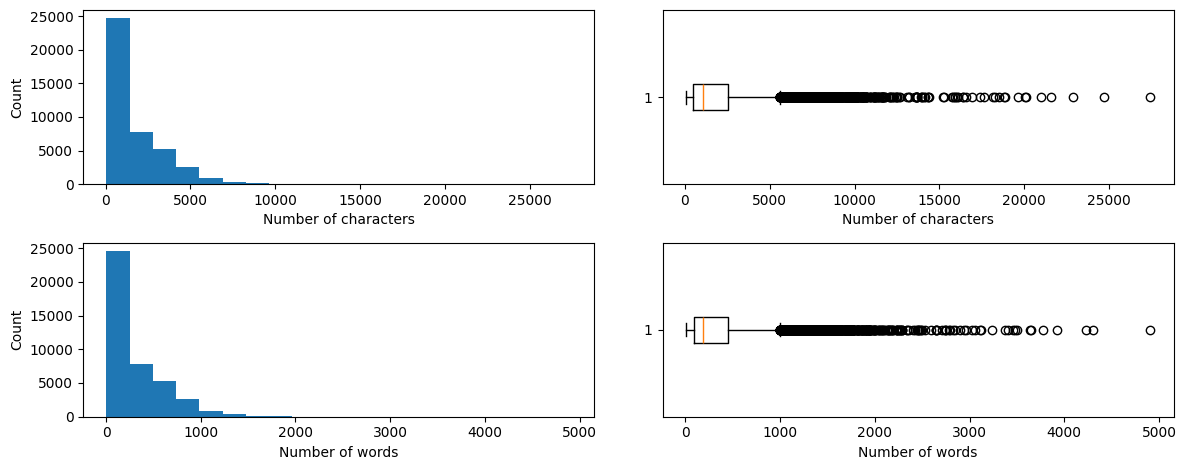

In [6]:
# Creating text length distribution visualisations
fig, ax = plt.subplots(2, 2) 

# Creating histogram 
ax[0,0].hist(df['text'].str.len(), bins=20) 
ax[0,0].set_xlabel('Number of characters') 
ax[0,0].set_ylabel('Count') 

ax[1,0].hist(df['text'].str.split().map(lambda x: len(x)), bins=20)
ax[1,0].set_xlabel('Number of words') 
ax[1,0].set_ylabel('Count') 

#Creating boxplots
ax[0,1].boxplot(df['text'].str.len(), vert=False)
ax[0,1].set_xlabel('Number of characters') 
ax[1,1].boxplot(df['text'].str.split().map(lambda x: len(x)), vert=False)
ax[1,1].set_xlabel('Number of words') 

fig.tight_layout()
fig.set_figwidth(13)

In [11]:
# Get english stopwords
stopwords = set(stopwords.words("english"))

# Function to remove stopwords
def remove_stopwords(text):
    no_stop = []
    for i in text.split():
        if i not in stopwords:
            no_stop.append(i)
    return " ".join(no_stop)

# Function to get a frequency plot
def freq_plot(text):
    words = " ".join([x for x in text])
    words = words.split()
    fdist = nltk.FreqDist(words)
    return fdist

# Function for generating word clouds
def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

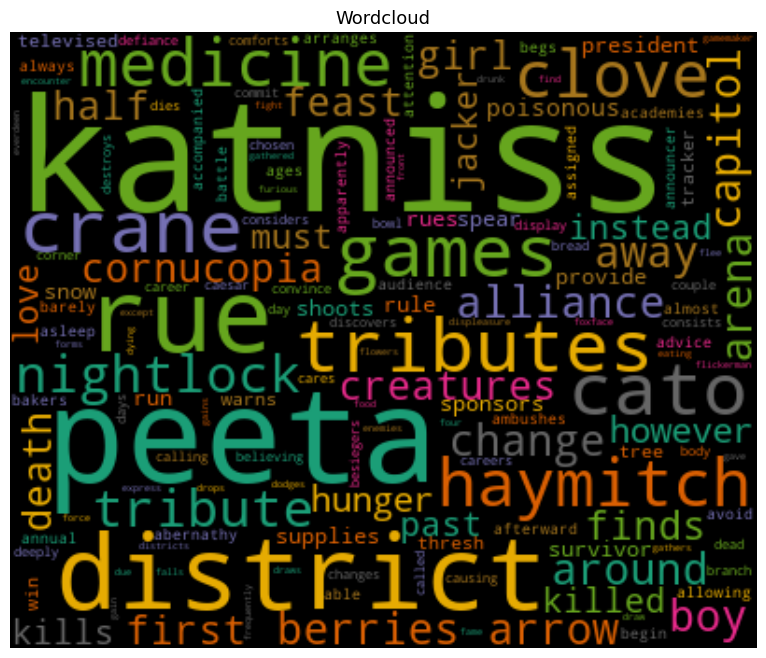

In [80]:
# Creating a wordcloud
# Creating a document term matrix
cv = CountVectorizer(analyzer='word')
data = cv.fit_transform(df['text'].apply(remove_stopwords))  # returns sparse DTM
# Extract one row from the DTM and expand it to all rows (from sparse to dense)
df_dtm = pd.DataFrame(data.getrow(1).toarray(), columns=cv.get_feature_names_out())
# Plot wordcloud
generate_wordcloud(df_dtm.iloc[0], 'Wordcloud')

[Text(0.5, 1.0, 'Stopword frequency')]

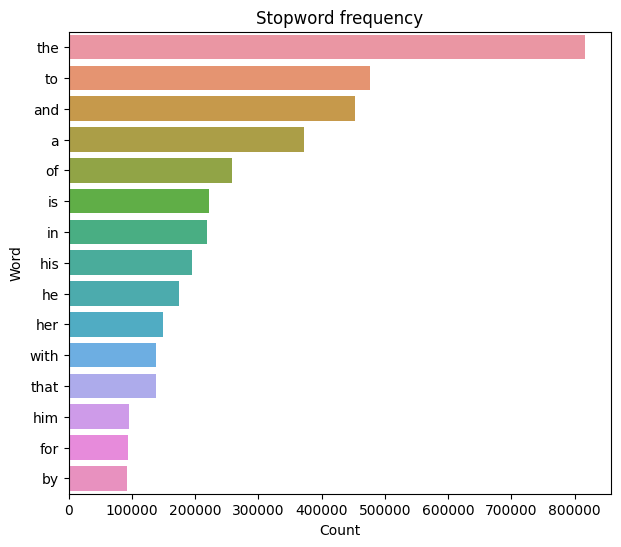

In [16]:
# Creating a stopwords frequency plot
fdist = freq_plot(df["text"])
words_df = pd.DataFrame.from_dict(fdist, orient="index")
words_df = words_df.reset_index()
words_df.columns = ["Word","Count"]

plt.figure(figsize=(7,6))
sns.barplot(data= words_df.sort_values(by="Count",ascending= False).iloc[:15, :], x = "Count", y= "Word").set(title='Stopword frequency')

### Genre visualisations

In [70]:
# Creating a genre frequency dataframe
flattened_list = [item for sublist in df['genre'] for item in sublist] # Flatten the dataframe column of lists
element_counts = Counter(flattened_list) # Count the number of elements in the flattened list
genre_counts = pd.DataFrame(sorted(element_counts.items(), key=lambda x:x[1], reverse=True)).rename(columns={0: "genre", 1: "count"})

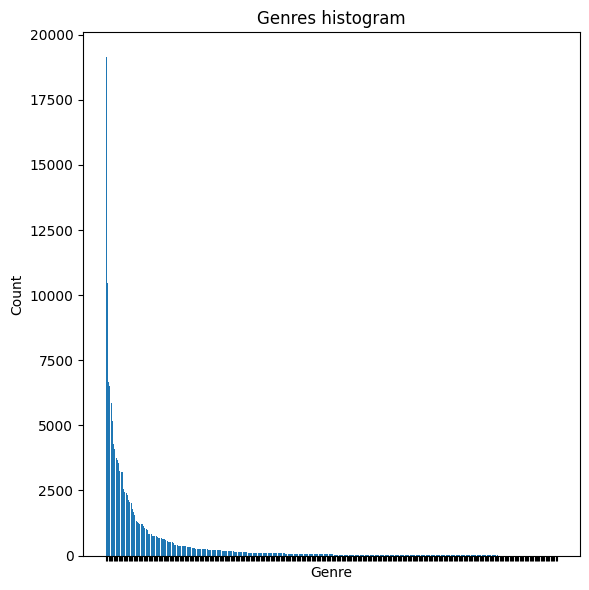

In [74]:
# Creating a genre histogram
plt.figure(figsize=(6, 6))
plt.bar(genre_counts['genre'], genre_counts['count'])
plt.xlabel('Genre')
plt.ylabel('Count')
plt.tick_params(axis='x', labelbottom=False)
plt.title('Genres histogram')
plt.tight_layout()
plt.show()

[Text(0, 0, 'Drama'),
 Text(1, 0, 'Comedy'),
 Text(2, 0, 'Romance Film'),
 Text(3, 0, 'Thriller'),
 Text(4, 0, 'Action'),
 Text(5, 0, 'World cinema'),
 Text(6, 0, 'Crime Fiction'),
 Text(7, 0, 'Horror'),
 Text(8, 0, 'Black-and-white'),
 Text(9, 0, 'Indie'),
 Text(10, 0, 'Action/Adventure'),
 Text(11, 0, 'Adventure'),
 Text(12, 0, 'Family Film'),
 Text(13, 0, 'Short Film'),
 Text(14, 0, 'Romantic drama'),
 Text(15, 0, 'Animation'),
 Text(16, 0, 'Musical'),
 Text(17, 0, 'Science Fiction'),
 Text(18, 0, 'Mystery'),
 Text(19, 0, 'Romantic comedy'),
 Text(20, 0, 'Fantasy'),
 Text(21, 0, 'Comedy film'),
 Text(22, 0, 'Crime Thriller'),
 Text(23, 0, 'War film'),
 Text(24, 0, 'Period piece'),
 Text(25, 0, 'Japanese Movies'),
 Text(26, 0, 'Comedy-drama'),
 Text(27, 0, 'Film adaptation'),
 Text(28, 0, 'Documentary'),
 Text(29, 0, 'Silent film'),
 Text(30, 0, 'Psychological thriller'),
 Text(31, 0, 'Bollywood'),
 Text(32, 0, 'Western'),
 Text(33, 0, 'Chinese Movies'),
 Text(34, 0, 'Black comedy'),

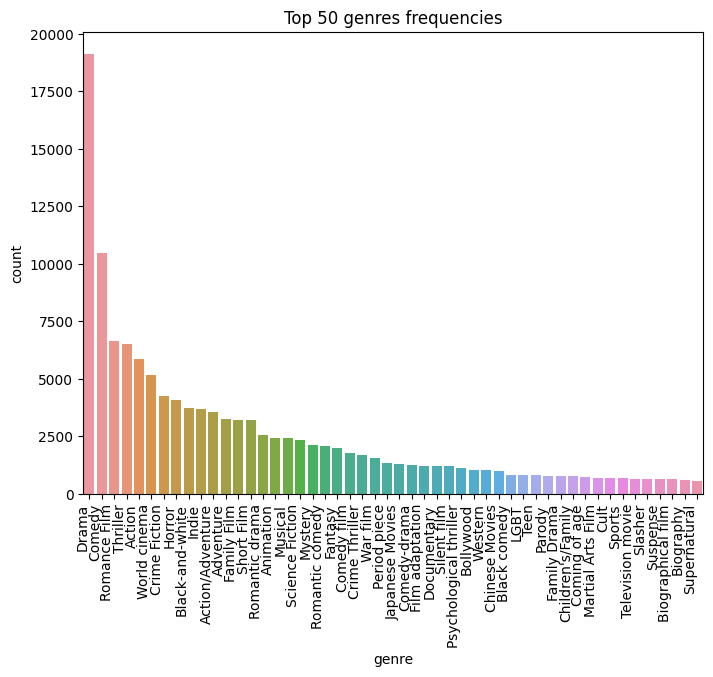

In [83]:
# Plotting the top 50 genres
plt.figure(figsize=(8,6))
plot = sns.barplot(data= genre_counts.iloc[:50, :], y = "count", x= "genre")
plot.set(title='Top 50 genres frequencies')
plot.set_xticklabels(genre_counts.iloc[:50, :]['genre'], rotation=90, horizontalalignment='right')